# Introduction to Reinforcement Learning
### London Self-Driving/Autonomous Car Technology Meetup

Sander van Dijk @ Parkopedia

27 February 2017

In [1]:
from __future__ import unicode_literals
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import time
from IPython import display

%matplotlib inline
%config NotebookBackend.figure_format = 'retina'

# Horrible Histories
## Reinforcing Rats

<table style="border: 0px;"><tr style="border: 0px;">
    <td style="border: 0px; padding: 40px;"><img src="rl/skinner.jpg" alt="Skinner" style="width: 200px;"/></td>
    <td style="border: 0px; padding: 40px"><img src="rl/skinnerbox.jpeg" alt="Skinner Box" style="width: 600px;"/></td>
</tr></table>

In the 40s, B.F. Skinner put animals into his 'Skinner Box': on pressing a lever, a rat would either get food, or an electric shock through its feet. This tested Skinner's 'Operant Conditioning' theory: changing of behavior by the use of reinforcement which is given after the desired response. Rats getting food learned to press the lever often, those getting shocks learned to stay away from it.

# Horrible Histories
## Rodent Junkies and Self-Pleasuring

<table style="border: 0px;"><tr style="border: 0px;">
    <td style="border: 0px; padding: 40px;"><img src="rl/selfadmin.jpg" alt="Rat self-administering drugs" style="width: 400px"></td>
    <td style="border: 0px; padding: 40px"><img src="rl/ratimplant.jpeg" alt="Rat with brain implant" style="width: 400px"></td>
</tr></table>


Scientists then turned it up a notch, and did the same experiments that didn't give out food, but where rodents could self administer drug injections such as cocaine or emphatamine, or could even directly give electrical stimulation to their brain's pleasure centres. The drugged rats would choose cocaine over food, prepared to starve themselves. This result is often cited in anti-drug campaigns, though later research showed that if the rodents were given the option to do other activities besides boring lever pressing, they used much less cocaine. The directly self-pleasuring rats however would ignore food, water, and mates in heat and just press the lever 1000s of times per hour.

# Learning Problems

* **Supervised Learning** - _Learn from labelled examples_<br>
    Image classification, parking availability prediction, behaviour cloning, ...


* **Unsupervised Learning** - _Find new structure in unlabelled data_<br>
    Clustering, anomaly detection, self-organising maps, ...


* **Reinforcement Learning** - _Learn from sparse, delayed reward_<br>
    Lever pressing, football, video games, ...

<center><img src="rl/rlloop.png" alt="Sensorimotor Loop"></center>

Reinforcement problems are modeled by a sense-action loop: the agent (animal/robot) is positioned in some environment. The agent observes the state of the environment with its senses. It processes these observations and in return performs a certain action, which affects the state of the environment. Additionally, the environment sometimes offers rewards to the agent when a series of chosen actions had a positive outcome (or negative reinforcement on a bad outcome).

# Formally: Markov Decision Process

* **State** of environment<br>$s$, $s'$

* **Action** chosen by agent<br>$a$, $a'$

* **Transition** model: how actions transform state<br>$T_{s, a}^{s'} = Pr(s'|s, a)$

* Agent's **policy**: how agent choses actions<br>$\pi(s, a) = Pr(a|s)$

* **Reward** function<br>$r_{s,a}^{s'} = R(s, a, s')$

# Goal: Maximise Expected Reward!

How much reward will the agent likely get from now until end of time?

Total reward of one episode:

<center>$ R^\infty = r_1 + r_2 + r_3 + \ldots + r_\infty $</center>

Based on a policy and transition model as defined above, you can calculate what the upfront expected total reward is, given that the world is in a specific state. In other words, this is the _value_ that that state has to an agent.

_Value function_ - total expected reward:

<center>$ V(s) = E[R^\infty | s] \\ ~ \\
~ = \sum_a \pi(s, a) \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + \sum_{a'} \ldots \\ ~ \\
~ = \sum_a \pi(s, a) \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + V(s') ]$</center>

To find the optimal states to be in, the agent is interested in the optimal value function:

<center>$V^*(s) = max_a \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + V^*(s') ]$</center>

This is a recursive function, that is infinitely dependent on itself, how could this be solved?

# Solution: Value Iteration

1. Start with random estimate of value function, $V_0(s)$
2. Iterate until convergence


<center>$V_{k+1}(s) = max_a \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + V_k(s') ]$</center>

Value iteration is guaranteed to converge onto the optimal value function.

# Example: Coco's Pizza Hunt

Coco the pug finds him self in a simple maze. He can smell his favourite food somewhere, pizza! He doesn't really know how to get there though, and he is only capable of moving in fixed sized steps parallel to the walls: up, down, left, or right.

In [2]:
def coco_world():
    """Creates a matrix representing the grid world"""
    world_mat = np.zeros((8, 13))
    world_mat[1:-1, 1:-1] = 1
    world_mat[1:4, 4] = 0
    world_mat[4:8, 8] = 0
    return world_mat

def draw_world(world_mat, coco_pos=None, goal_pos=None, fig=None):
    """Draw the grid world with agent and goal if given
    
    This uses the EmojiOne Color font: https://github.com/eosrei/emojione-color-font,
    change the characters below if you don't want to install it."""
    if fig is None:
        fig = plt.figure(figsize=reversed(np.array(world.shape) * 0.66))

    plt.clf()
    plt.imshow(world_mat, cmap='bone')
    if coco_pos is not None:
        plt.text(*reversed(coco_pos), '🐶', fontname='EmojiOne Color', fontsize=40,
                 horizontalalignment='center', verticalalignment='center', color='brown')
    if goal_pos is not None:
        plt.text(*reversed(goal_pos), '🍕', fontname='EmojiOne Color', fontsize=40,
                horizontalalignment='center', verticalalignment='center', color='red')
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

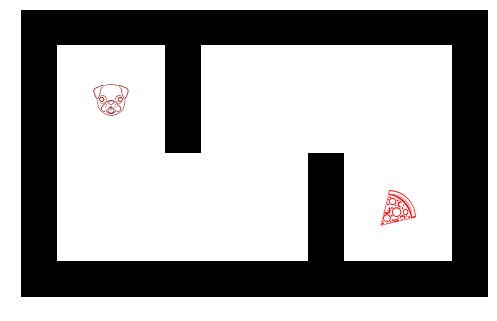

In [3]:
world = coco_world()
draw_world(world, coco_pos=(2, 2), goal_pos=(5, 10))

Initially he has no idea how to navigate in this world, so all he can do is just walk around randomly.

In [4]:
def action_target_coord(state_coord, action):
    """Function that determines which state an action would lead too if unobstructed"""
    if action == 0:
        return [state_coord[0] + 1, state_coord[1]]
    elif action == 1:
        return [state_coord[0], state_coord[1] + 1]
    elif action == 2:
        return [state_coord[0] - 1, state_coord[1]]
    elif action == 3:
        return [state_coord[0], state_coord[1] - 1]

def state_index(state_coords, state_coord):
    """Map an x,y coordinate to an index"""
    return np.where((state_coords == state_coord).all(axis=1))[0][0]


In [5]:
def random_policy():
    """Policy that picks each action with equal probability"""
    return lambda s: [0.25, 0.25, 0.25, 0.25]

def step_policy(world_mat, coco_pos, policy):
    """Choose a single action according to the given policy and update the world state accordingly"""
    states = world_mat != 0
    state_coords = np.argwhere(states)
    state = state_index(state_coords, coco_pos)
    action = np.random.choice(4, p=policy(state))
    target_coord = action_target_coord(coco_pos, action)
    if world_mat[tuple(target_coord)] == 0:
        target_coord = coco_pos
    return target_coord

def run_policy(world, coco_pos, goal_pos, policy, n_steps):
    """Run policy for a number of steps, drawing the world state at each iteration"""
    fig = plt.figure(figsize=reversed(world.shape))
    draw_world(world, coco_pos, goal_pos, fig)

    for i in range(0, n_steps):
        coco_pos = step_policy(world, coco_pos, policy)
        draw_world(world, coco_pos, goal_pos, fig)

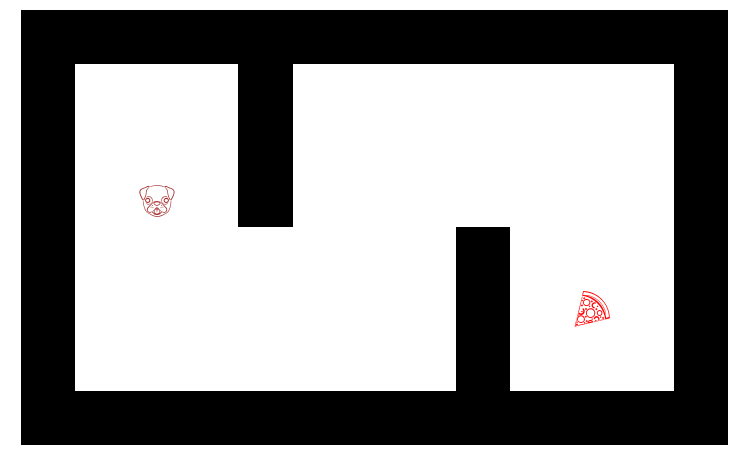

In [6]:
policy = random_policy()
coco_pos = (2, 2)
goal_pos = (5, 10)
run_policy(world, coco_pos, goal_pos, policy, 30)

# Example: Value Iteration

Now we can perform value iteration to have Coco informed about the actual value of being in each state, i.e. how likely it is that he would make it to the pizza for each state.

In [7]:
def create_transition_model(world_mat, noise=0):
    """Build a 3D array that represents the world's transition model
    
    Indexing the model at [s, a, s'] gives the probability that performing action `a` in state `s`
    results in the new state `s'`. The noise level controls the accuracy of actions: e.g. with a level of 0.1,
    when Coco tries to move right, he has a probility of 0.1 to actually move up, 0.1 to move down, 0.1 to move left,
    and 0.7 of actually moving to the right.
    """
    states = world_mat != 0
    state_coords = np.argwhere(states)
    n_states = len(state_coords)
    model = np.zeros((n_states, 4, n_states))
    for state in range(0, n_states):
        state_coord = state_coords[state]
        for action in range(0, 4):
            for actual_action in range(0, 4):
                target_coord = action_target_coord(state_coord, actual_action)
                if world_mat[tuple(target_coord)] == 0:
                    target_coord = state_coord
                next_state = state_index(state_coords, target_coord)
                model[state, action, next_state] = 1 - 3 * noise if action == actual_action else noise
    return model

def create_reward_function(world_mat, goal_pos, trap_pos=None):
    """Build an array that represents the world's reward function
    
    In this example the reward is only based on the state the agent gets into, so the function is a 1D vector.
    """
    states = world_mat != 0
    state_coords = np.argwhere(states)
    n_states = len(state_coords)
    
    reward_function = np.zeros(n_states)
    reward_function[state_index(state_coords, goal_pos)] = 1
    if trap_pos is not None:
        reward_function[state_index(state_coords, trap_pos)] = -1

    return reward_function

def create_random_value_function(world_mat):
    states = world_mat != 0
    state_coords = np.argwhere(states)
    n_states = len(state_coords)

    return np.random.rand(n_states)

In [8]:
def draw_value_function(world_mat, value_function, fig=None):
    if fig is None:
        fig = plt.figure(figsize=reversed(np.array(world.shape) * 0.66))

    plt.clf()
    value_function_mat = world_mat.copy()
    states = world_mat != 0
    state_coords = np.argwhere(states)

    for state_coord, value in zip(state_coords, value_function):
        value_function_mat[tuple(state_coord)] = value
    plt.imshow(value_function_mat, cmap='hot')
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [9]:
def value_iteration(value_function, reward_function, transition_model, gamma=0.9):
    """Performs a single iteration of the value iteration algorithm to update the value function towards the optimal
    
    `gamma` is a discount factor used here so that the infinite sum of reward does not explode
    """
    next_state_values = reward_function + gamma * value_function
    new_value_function = np.zeros_like(value_function)
    for state in range(0, len(value_function)):
        max_value = -1e6
        for action in range(0, 4):
            transition_probs = transition_model[state, action, :]
            expected_value = (transition_probs * next_state_values).sum()
            if expected_value > max_value:
                max_value = expected_value
        new_value_function[state] = max_value
        
    return new_value_function

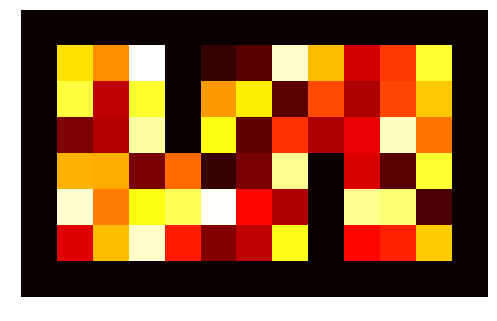

In [10]:
transition_model = create_transition_model(world)
reward_function = create_reward_function(world, goal_pos=(5, 10))
value_function = create_random_value_function(world)
draw_value_function(world, value_function)

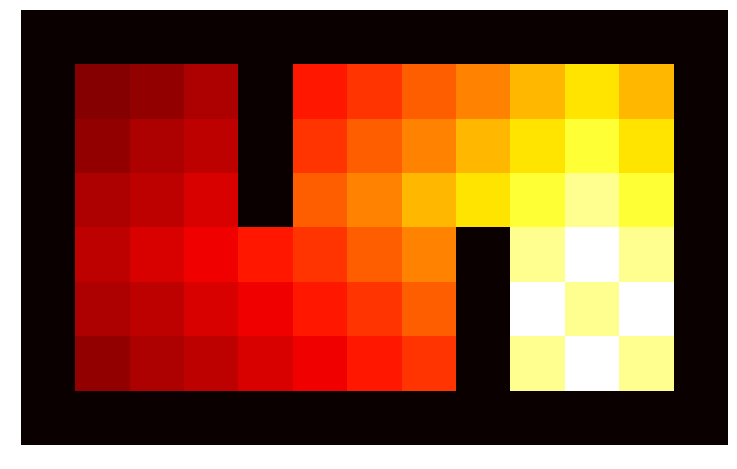

In [11]:
fig = plt.figure(figsize=reversed(world.shape))
for i in range(0, 25):
    value_function = value_iteration(value_function, reward_function, transition_model)
    draw_value_function(world, value_function, fig)
    time.sleep(0.25)

# Optimal Policy

Once optimal value function is found, finding optimal policy is trivial:

<center>$ \pi^*(s, a) = 1 : a = \underset{a}{\operatorname{argmax}} \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + V^*(s') ] $</center>

_Pick action leading to maximum value_

In [12]:
def determine_optimal_policy(world_mat, reward_function, value_function, gamma=0.9):
    """Creates a policy that picks actions that lead to states with the highest expected reward"""
    next_state_values = reward_function + gamma * value_function
    policy_mat = np.zeros((len(reward_function), 4))
    for state in range(0, len(policy_mat)):
        max_value = -1e6
        best_action = -1
        for action in range(0, 4):
            transition_probs = transition_model[state, action, :]
            expected_value = (transition_probs * next_state_values).sum()
            if expected_value > max_value:
                max_value = expected_value
                best_action = action
        policy_mat[state, best_action] = 1
    
    return lambda s: policy_mat[s]

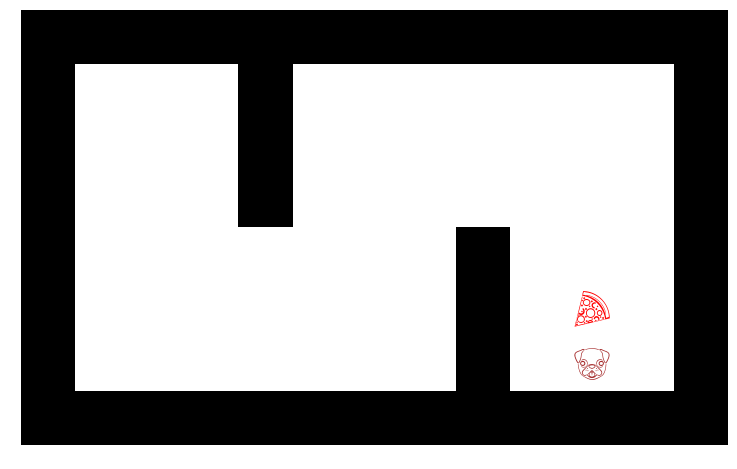

In [13]:
policy = determine_optimal_policy(world, reward_function, value_function)
coco_pos = [np.random.choice(np.arange(1, 6)), np.random.choice(np.arange(1, 3))]
run_policy(world, coco_pos, goal_pos, policy, 20)

# Adding Negative Reinforcement and Noise
The reward function can have more complex designs, and with noise negative reward is spread to surrounding states.

In [14]:
transition_model = create_transition_model(world, noise=0.15)
reward_function = create_reward_function(world, goal_pos=(5, 10), trap_pos=(2, 6))
value_function = create_random_value_function(world)

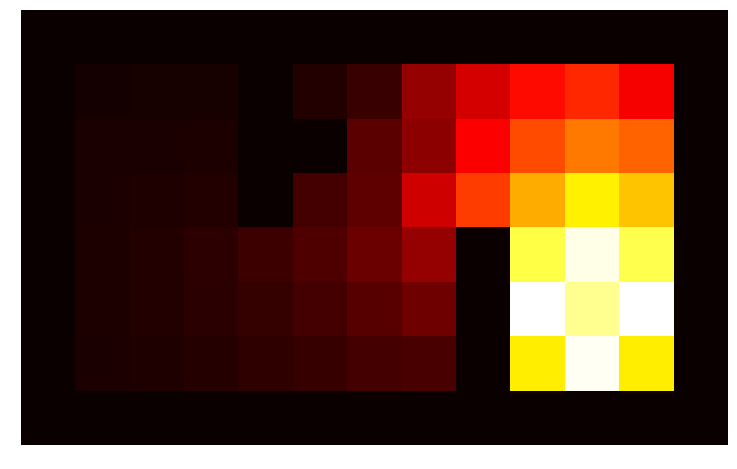

In [15]:
fig = plt.figure(figsize=reversed(world.shape))
for i in range(0, 25):
    value_function = value_iteration(value_function, reward_function, transition_model)
    draw_value_function(world, value_function, fig)
    time.sleep(0.25)

# Solved! Or..?
* Infinite sum of reward - 'discount' factor $0 \le \gamma \le 1$ tradiing off long term and short term reward

    <center>$ \sum_a \pi(s, a) \sum_{s'} [ T_{s, a}^{s'} \cdot r_{s,a}^{s'} + \color{red}{\gamma} V(s') ]$ </center>
    

* Reward function design - narrow sighted greed, unwanted effects


* **This is not Reinforcement Learning!**

# Real Reinforcement Learning

Coco knows too much!

* Do you always know the consequences of your actions? $T_{s,a}^{s'}$ unknown!
* What are the good outcomes? $R(s, a, s')$ unknown

Options:
1. Learn models from experience at the same time
2. Model free learning

Reinforcement learning models learn through trial and error: the agent performs an action and gains a single sample of 'experience' $<s, a, s' r>$. Such samples give sparse bits of information about the transition model and reward function, that the agent can use to learn how to maximise his expected reward.

# Temporal Difference (TD) Learning: No More Models

Idea: a single time step already gives some information about value.

1. Start with random value function and some policy
2. Observe current state $s$
3. Perform action $a$ based on policy
4. Observe new state $s$ and immediate reward $r$
5. Update value of previous state: $V(s) \leftarrow V(s) + \alpha [r + \gamma V(s') - V(s)]$
6. Goto 2

Problem: learns value of current policy, not optimal policy; '_On-Policy_'

# Q-Learning: Off-Policy Learning

Idea: assign value to state-action pair: $Q(s, a)$

1. Start with random Q-value function
2. Observe current state $s$
3. Perform action $a$ based on policy _derived from Q_
4. Observe new state $s$ and immediate reward $r$
5. Update value of previous state-action: $Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_a' Q(s', a') - Q(s, a)]$
6. Goto 2

Can learn optimal value + policy, even when just acting randomly!

# State of the Art RL! ... in 1989

Can't really deal with:
* Huge spaces (camera feed, Atari screen, Go board, ...)
* Continuous spaces (steering angles, joint motor angles, ...)

Needed: _Function approximation_:
* Learn parameters $\theta$ of some function $f_\theta(s, a)$ to approximate $Q(s,a)$
* Linear regression, (deep) neural network, ...

Everything so far assumed all values can be kept in nice tables. Very high dimensional spaces will make those blow up, and it will not be likely that all states will be visited. Continuous actions make it even impossible to use tables, and at least some sort of function approximation is needed.

# Continuous actions
So, function approximation! But...

* Not guaranteed to converge (but let's forget about that for now...)
* Find best action? Search action space? Evaluate $Q(s,a)$ many times..

Split learner into two parts:
1. Critic - learns value function
2. Actor - learns best actions

# Actor-Critic Methods

<center><img src="rl/actorcritic.png" alt="Actor-Critic Model"></center>

The critic learns a value function like before. The actor however learns the policy separately from this value function, based on the TD (value prediction) error: if an action turned out to be more valuable than initially thought, its probability should be increased. Having a separate actor prevents having to evaluate the value function continously, and you can ship the actor separate from the value function.

# Deep Q Learning


<center><img src="rl/atarigames.png" alt="Atari Games" width="600"></center>


* DeepMind - [Nature, February 2015](http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html)
* Learned to play Atari games purely from pixel input
* Use CNN to learn Q-value
* Limited amount of discreet actions


# Catastrophic Forgetting

Learning in one area can undo learning in another. Stability trick: _experience replay_

<img src="rl/experiencememory.png" width="400">

When an agent is activally learning, it will gather many samples in the same area of state space. Learning from these samples will make the value function and policy more adapt to this area, but doing so changes parameters of the functions that affect all areas. This could undo previously learned behaviour. Using experience replay, the agent stores all his experiences, and trains on random samples from this memory, rather than on the latest experience. This ensures more variance, and alleviates catastrophic forgetting and behaviour divergence.

# Learning to Drive?

DeepMind - [ICLR 2016](https://arxiv.org/abs/1509.02971), Deep Actor-Critic Method

<img src="rl/driving.png" width="400">


This method uses a deep network both for value function and policy. This allows it to learn problems with continuous actions, such as pole balancing, bipedal walking, and: driving around a simulated race course.

# Simulation is Cool, but...

Results difficult to transfer to real world:
* Use racing game policy in the City?
* Simulation never perfect: overfitting
* 'Crash into wall' reinforcement not useful in real car
* Tesla, Uber, Nvidia, Google are on it!

<img src="rl/crashed-model-s.jpg" width="400">

Overfitting can happen both on the similation artifacts, and the chosen reward function. Currently the main approach is to learn from example human behaviour: cloning a human policy, which boils down to supervised learning.

# Making it more Human: Hierarchy

<table style="border: 0px;"><tr style="border: 0px;">
    <td style="border: 0px; padding: 40px;"><img src="rl/hierarchy.png" alt="Hierarchy" style="width: 500px;"/></td>
    <td style="border: 0px; padding: 40px"><img src="rl/fmri.jpg" alt="fMRI scan" style="width: 300px;"/></td>
</tr></table>

Humans don't just think in basic actions like 'move joint to angle', we plan at different layers of abstraction. At each level we run policies that get finer moving down the hierarchy. In the field of RL there has been much work on 'Hierarchical Reinforcement Learning', most notibly using the 'Options' framework. In the last decade, Botvinick and Barto have mapped this theory to actual structures in the human brain.

# Making it more Human: Back to Models

<img src="rl/modelbased.png">

[Cambridge + Google Brain + DeepMind, 2016](https://arxiv.org/pdf/1603.00748.pdf)

# Resources

* ['The Book'](https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html) - Reinforcement Learning, Sutton & Barto
* [Demystifying Deep Reinforcement Learning](https://www.nervanasys.com/demystifying-deep-reinforcement-learning/)
* [Berkeley Deep RL Course](http://rll.berkeley.edu/deeprlcourse/)
* [Reinforcement Learning: Top 10 Breakthrough Technologies](https://www.technologyreview.com/s/603501/10-breakthrough-technologies-2017-reinforcement-learning/) - As judged by MIT Technology Review

# Deep Q-Network

<img src="rl/deepqnetwork.png" width="600">

The network used to approximae the Q-function is a CNN with two convolution layers and two fully connected layers, so not very deep.

Also, there are no pooling layers. Pooling are useful to increase spatial invariance: if you want to recognise a cat it should not matter where in the image the cat is. In video games on the other hand the accurate location of objects on the screen is very important.

Rather than using the state-action pair as input and calculating a single Q value as output, the network is trained to output the value of all actions given a state directly, so that only one feedforward pass is needed to find the best action.

# Stability Trick 2: Fixed Target Q-Network

* Fix old network with parameters $\theta^-$ and calculate target with those:

    $ r + \max_{a'} Q_{\color{red}{\theta^-}}(s', a') - Q_{\color{red}{\theta}}(s, a)$


* Periodically update: $\theta^- \leftarrow \theta$


* Breaks correlation network and target, avoids oscillations

# Stability Trick 3: Clip Reward/Value

* Clip reward to $[-1, +1]$


* Avoid huge overestimation of Q-value


* Learning gradients well-conditioned


* Problem: no difference small/large rewards

# RL Drifting

In [16]:
from IPython.display import YouTubeVideo

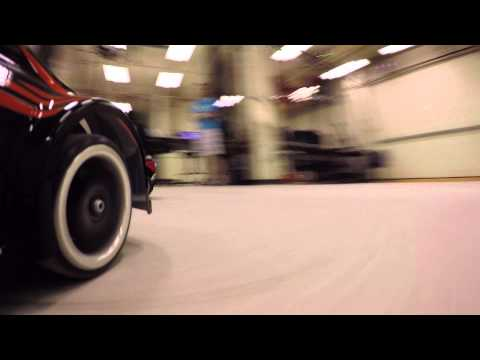

In [17]:
YouTubeVideo('opsmd5yuBF0', width=800, height=480)